In [1]:
import os
from pprint import pprint
import torch
from tiatoolbox.wsicore.wsireader import VirtualWSIReader, WSIReader
from tiatoolbox.tools.patchextraction import get_patch_extractor
from tissue_masker_lite import get_mask
import matplotlib.pyplot as plt
import numpy as np
from tiatoolbox.models.engine.semantic_segmentor import SemanticSegmentor
import segmentation_models_pytorch as smp
from tqdm.auto import tqdm
import cv2
import pickle
import skimage
import cv2
import skimage.measure
from torch.utils.data import DataLoader
from torchvision.transforms.v2.functional import resize

|2024-05-14|16:23:19.490| [WARNING] /home/u1910100/miniconda3/envs/TIAToolBox/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()

|2024-05-14|16:23:19.490| [WARNING] /home/u1910100/miniconda3/envs/TIAToolBox/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details

In [ ]:
mask = np.load("/home/u1910100/GitHub/TIAger-Torch/output/temp_out/110S.npy")
print(np.shape(mask))

|2024-05-14|16:23:25.527| [WARNING] Metadata: Falling back to TIFF resolution tag for microns-per-pixel (MPP).
|2024-05-14|16:23:25.527| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


{'axes': 'YXS',
 'file_path': PosixPath('/home/u1910100/Documents/Tiger_Data/wsitils/images/110S.tif'),
 'level_count': 8,
 'level_dimensions': ((73408, 46976),
                      (36704, 23488),
                      (18352, 11744),
                      (9176, 5872),
                      (4588, 2936),
                      (2294, 1468),
                      (1147, 734),
                      (573, 367)),
 'level_downsamples': [1.0,
                       2.0,
                       4.0,
                       8.0,
                       16.0,
                       32.0,
                       64.0,
                       128.05584642233856],
 'mpp': (0.45669399219053275, 0.45669399219053275),
 'objective_power': 20.0,
 'slide_dimensions': (73408, 46976),
 'vendor': 'generic-tiff'}


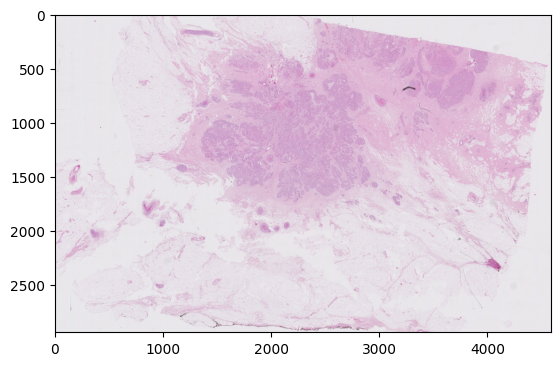

|2024-05-14|16:23:26.642| [WARNING] Raw data is None.
|2024-05-14|16:23:26.643| [WARNING] Unknown scale (no objective_power or mpp)


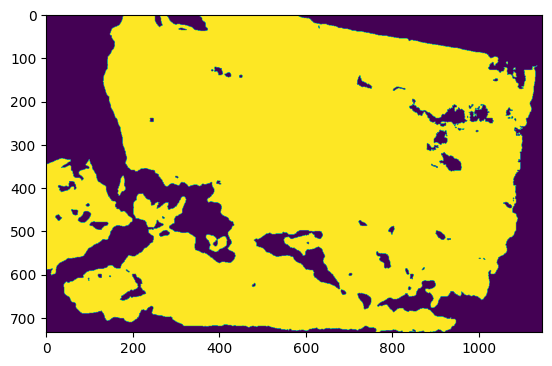

In [2]:
wsi_name = "110S.tif"
wsi_without_ext = os.path.splitext(wsi_name)[0]
wsi_dir = "/home/u1910100/Documents/Tiger_Data/wsitils/images/"
wsi_path = os.path.join(wsi_dir, wsi_name)
image = WSIReader.open(wsi_path)
pprint(image.info.as_dict())
dimensions = image.slide_dimensions(resolution=10, units="power")

thumb = image.slide_thumbnail(resolution=1.25, units="power")
plt.imshow(thumb)
plt.show()

# mask = get_mask(
#     wsi_path=wsi_path,
#     save_dir="output/temp_out",
#     model_weight="/home/u1910100/GitHub/tissue_masker_lite/tissue_masker_lite/model_weights/model_22.pth",
# )
mask = np.load(f"output/temp_out/{wsi_without_ext}.npy")[:, :, 0]
mask = VirtualWSIReader.open(mask, mpp=8, power=1.25, mode="bool")
mask_thumb = mask.slide_thumbnail(resolution=32, units="mpp")
# print(np.count_nonzero(mask_thumb[:,:,0]))
plt.imshow(mask_thumb[:, :, 0])
plt.show()

In [3]:
def imagenet_normalise(img: torch.tensor) -> torch.tensor:
    """Normalises input image to ImageNet mean and std"""

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    for i in range(3):
        img[:, i, :, :] = (img[:, i, :, :] - mean[i]) / std[i]
    return img

In [4]:
segModel1 = "/home/u1910100/GitHub/TIAger-Torch/runs/tissue/fold_1/model_59.pth"
segModel2 = "/home/u1910100/GitHub/TIAger-Torch/runs/tissue/fold_3/model_41.pth"
segModel3 = "/home/u1910100/GitHub/TIAger-Torch/runs/tissue/fold_4/model_35.pth"
segModel = [segModel1, segModel2, segModel3]

models: list[torch.nn.Module] = []
for model_path in segModel:
    model = smp.Unet(
        encoder_name="efficientnet-b0",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,  # model output channels (number of classes in your dataset)
    )

    model.load_state_dict(torch.load(model_path))

    model.to("cuda")
    model.eval()
    models.append(model)

In [5]:
patch_extractor = get_patch_extractor(
    input_img=image,
    method_name="slidingwindow",
    patch_size=(512, 512),
    stride=(384, 384),
    resolution=10,
    units="power",
    input_mask=mask,
)

down_dimensions = dimensions = image.slide_dimensions(resolution=0.3125, units="power")

tumor_predictions: list[np.ndarray] = []
stroma_predictions: list[np.ndarray] = []

batch_size = 4
dataloader = DataLoader(patch_extractor, batch_size=batch_size, shuffle=False)

for i, imgs in enumerate(tqdm(dataloader, leave=False)):
    imgs = torch.permute(imgs, (0, 3, 1, 2))
    imgs = imgs / 255
    imgs = imagenet_normalise(imgs)
    imgs = imgs.to("cuda").float()

    val_predicts = np.zeros(shape=(imgs.size()[0], 3, 16, 16), dtype=np.float32)

    with torch.no_grad():
        for seg_model in models:
            temp_out = seg_model(imgs)
            temp_out = torch.nn.functional.softmax(temp_out, dim=1)
            temp_out = resize(temp_out, (16, 16))

            temp_out = temp_out.detach().cpu().numpy()

            val_predicts += temp_out

    pred = np.argmax(val_predicts, axis=1, keepdims=True)
    pred = pred[:, 0, :, :].astype(np.uint8)
    tumor_map = np.zeros((imgs.size()[0], 16, 16), dtype=np.uint8)
    # stroma_map = np.zeros((imgs.size()[0], 512, 512), dtype=np.uint8)
    # 1 -> tumor, 2-> stroma
    tumor_map[np.where(pred == 1)] = 1
    # stroma_map[np.where(pred == 2)] = 1
    tumor_predictions.extend(list(tumor_map))
    # stroma_predictions.extend(list(stroma_map))

# down_coords = [int(coords/32) for coords in patch_extractor.coordinate_list]

# tumor_mask = SemanticSegmentor.merge_prediction(
#     (down_dimensions[1], down_dimensions[0]), tumor_predictions, down_coords
# )
# tumor_mask = (tumor_mask > 0.5).astype(np.uint8)

# plt.imshow(tumor_mask)
# plt.show()
# np.save(f"output/seg_out/{wsi_without_ext}_tumor.npy", tumor_mask[:, :, 0])

# stroma_mask = SemanticSegmentor.merge_prediction(
#     (dimensions[1], dimensions[0]), stroma_predictions, patch_extractor.coordinate_list
# )
# stroma_mask = (stroma_mask > 0.5).astype(np.uint8)
# np.save(f"output/seg_out/{wsi_without_ext}_stroma.npy", stroma_mask[:, :, 0])

  0%|          | 0/1174 [00:00<?, ?it/s]

(734, 1147)
uint8


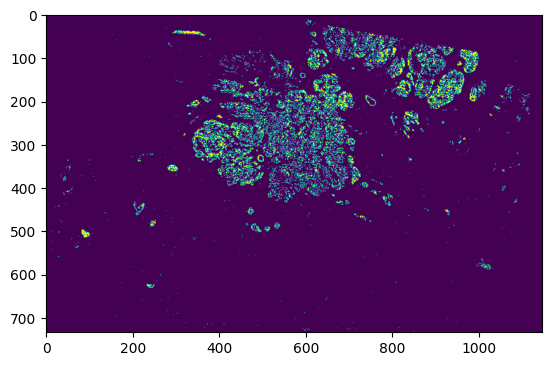

In [17]:
down_coords = [coords // 32 for coords in patch_extractor.coordinate_list]

tumor_mask = SemanticSegmentor.merge_prediction(
    (down_dimensions[1], down_dimensions[0]), tumor_predictions, down_coords
)
tumor_mask = (tumor_mask > 0.5).astype(np.uint8)[:, :, 0]
print(tumor_mask.shape)
print(tumor_mask.dtype)
plt.imshow(tumor_mask)
plt.show()

uint8
(734, 1147)


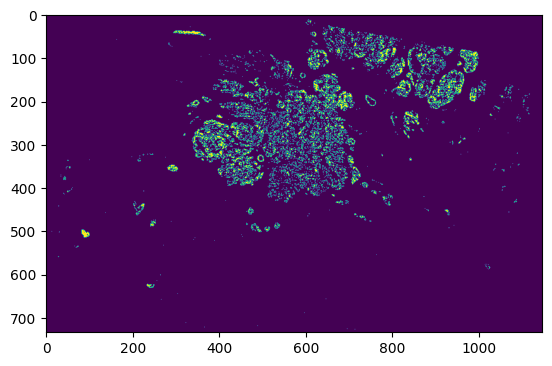

In [18]:
v1_tumor_mask = np.load("output/seg_out/110S_tumor.npy")
plt.imshow(v1_tumor_mask)
print(v1_tumor_mask.dtype)
print(v1_tumor_mask.shape)

In [19]:
dice = (
    np.sum(tumor_mask[v1_tumor_mask == 1])
    * 2.0
    / (np.sum(tumor_mask) + np.sum(v1_tumor_mask))
)

print("Dice similarity score is {}".format(dice))

Dice similarity score is 0.895918517971806


Create Tumor Bulk

In [ ]:
def mm2_to_px(mm2, mpp):
    return (mm2 * 1e6) / mpp**2


def dist_to_px(dist, mpp):
    dist_px = int(round(dist / mpp))
    return dist_px


def px_to_mm(px, mpp):
    return px * mpp / 1000


def px_to_um2(px, mpp):
    area_um2 = px * (mpp**2)
    return area_um2


def get_tumor_bulk(tumor_seg_mask):
    binary_tumor_mask = tumor_seg_mask.astype(bool)
    mpp = 32
    min_size_px = mm2_to_px(1.0, mpp)
    kernel_diameter = dist_to_px(1000, mpp)

    wsi_patch = skimage.morphology.remove_small_objects(
        binary_tumor_mask, min_size=mm2_to_px(0.005, mpp), connectivity=2
    )
    wsi_patch = wsi_patch.astype(np.uint8)
    # plt.imshow(wsi_patch)
    # plt.show()

    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (kernel_diameter, kernel_diameter)
    )
    closing = cv2.morphologyEx(wsi_patch, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
    wsi_patch = opening
    wsi_patch = wsi_patch.astype(bool)
    wsi_patch = skimage.morphology.remove_small_objects(
        wsi_patch, min_size=min_size_px, connectivity=2
    )
    # plt.imshow(wsi_patch)
    # plt.show()

    labels = skimage.measure.label(wsi_patch)
    tumor_bulk = labels == np.argmax(np.bincount(labels.flat)[1:]) + 1
    # plt.imshow(tumor_bulk)
    # plt.show()
    return tumor_bulk


def get_tumor_stroma_mask(bulk_tumor_mask, stroma_mask):
    tumor_stroma_mask = bulk_tumor_mask * stroma_mask
    # plt.imshow(tumor_stroma_mask)
    # plt.show()
    mpp = 32
    kernel_diameter = dist_to_px(1000, mpp)
    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (kernel_diameter, kernel_diameter)
    )
    closing = cv2.morphologyEx(tumor_stroma_mask, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
    tumor_stroma_mask = opening
    # plt.imshow(tumor_stroma_mask)
    # plt.show()
    return tumor_stroma_mask

In [ ]:
tumor_mask_path = (
    f"/home/u1910100/GitHub/TIAger-Torch/output/seg_out/{wsi_without_ext}_tumor.npy"
)
stroma_mask_path = (
    f"/home/u1910100/GitHub/TIAger-Torch/output/seg_out/{wsi_without_ext}_stroma.npy"
)
# def create_tumor_stroma_mask(tumor_mask_path, stroma_mask_path):
tumor_mask = np.load(tumor_mask_path)
tumor_mask = VirtualWSIReader.open(tumor_mask, power=10, mode="bool")

tumor_mask_thumb = tumor_mask.slide_thumbnail(resolution=0.3125, units="power")
binary_tumor_mask = tumor_mask_thumb[:, :, 0]
plt.imshow(binary_tumor_mask)
plt.show()
tumor_bulk = get_tumor_bulk(binary_tumor_mask)
plt.imshow(tumor_bulk)
plt.show()

stroma_mask = np.load(stroma_mask_path)
stroma_mask = VirtualWSIReader.open(stroma_mask, power=10, mode="bool")
stroma_mask_thumb = stroma_mask.slide_thumbnail(resolution=0.3125, units="power")
binary_stroma_mask = stroma_mask_thumb[:, :, 0]
plt.imshow(binary_stroma_mask)
plt.show()

tumor_stroma_mask = get_tumor_stroma_mask(tumor_bulk, binary_stroma_mask)
tumor_stroma_mask = tumor_stroma_mask.astype(np.uint8)
plt.imshow(tumor_stroma_mask)
plt.show()
np.save(f"output/seg_out/{wsi_without_ext}_tumor_stroma.npy", tumor_stroma_mask)